In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util.plot import plot_cdf,plot_lines,plot_box_by_config,plot_grouped_boxplots,plot_bars
from util.consts import balance_size_bins, balance_size_bins_label
from util.plot import color_list
import json
import os
from collections import defaultdict

In [89]:
from util.consts import get_base_delay_path,get_base_delay_transmission
lr=10
dir_prev='/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_test'
dir_curr='/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_debug'
for scenario_idx in [0]:
    sizes_prev=np.load(f'{dir_prev}/{scenario_idx}/ns3/fsize.npy')
    sizes_curr=np.load(f'{dir_curr}/{scenario_idx}/ns3/fsize.npy')[fid]
    print(f"{scenario_idx}: {sizes_prev.shape} {sizes_curr.shape}")
    fid=np.load(f'{dir_curr}/{scenario_idx}/ns3/fid_topology_flows.npy')
    fcts_gt=np.load(f'{dir_prev}/{scenario_idx}/ns3/fct_topology_flows.npy')
    fcts_i_gt=np.load(f'{dir_prev}/{scenario_idx}/ns3/fct_i_topology_flows.npy')
    
    dir_input_tmp=f'{dir_prev}/{scenario_idx}/ns3'
    link_list = np.load(
        f"{dir_input_tmp}/flink.npy",
    )
    link_dict = {link: idx for idx, link in enumerate(link_list)}
    link_info = np.load(
        f"{dir_input_tmp}/flow_to_path.npy",
        allow_pickle=True,
    )
    link_info = [[link_dict[link] for link in link_info[i]] for i in fid]

    flowid_to_linkid = defaultdict(list)
    edges_list = []
    for flow_idx in range(len(fid)):
        for link_idx in link_info[flow_idx]:
            edges_list.append([flow_idx, link_idx])
            flowid_to_linkid[flow_idx].append(link_idx)
    edges_list = np.array(edges_list).T

    n_links_passed = np.array([len(path) for path in link_info])
    base_delay = get_base_delay_path(sizes_prev, n_links_passed, lr)
    
    fcts_flowsim_prev=np.load(f'{dir_prev}/{scenario_idx}/ns3/flowsim_fct.npy')+base_delay
    fcts_flowsim_curr=np.load(f'{dir_curr}/{scenario_idx}/ns3/flowsim_fct.npy')[fid]+base_delay
    i_fcts_flowsim = get_base_delay_transmission(sizes_prev, lr) + base_delay
    print(fcts_flowsim_prev.shape,fcts_flowsim_curr.shape)
    
    sldn_gt=np.divide(fcts_gt,fcts_i_gt)[-10000:]
    sldn_flowsim_prev=np.divide(fcts_flowsim_prev,i_fcts_flowsim)[-10000:]
    sldn_flowsim_curr=np.divide(fcts_flowsim_curr,i_fcts_flowsim)[-10000:]
    
    error_prev=np.abs(sldn_gt-sldn_flowsim_prev)/sldn_gt*100
    error_curr=np.abs(sldn_gt-sldn_flowsim_curr)/sldn_gt*100
    print(f"Error: {np.mean(error_prev)} {np.mean(error_curr)}")
    
    sldn_p99_gt=np.percentile(sldn_gt,99)
    sldn_p99_flowsim_prev=np.percentile(sldn_flowsim_prev,99)
    sldn_p99_flowsim_curr=np.percentile(sldn_flowsim_curr,99)
    print(f"p99: {sldn_p99_gt} {sldn_p99_flowsim_prev} {sldn_p99_flowsim_curr}")
    error_p99_prev=np.abs(sldn_p99_gt-sldn_p99_flowsim_prev)/sldn_p99_gt*100
    error_p99_curr=np.abs(sldn_p99_gt-sldn_p99_flowsim_curr)/sldn_p99_gt*100
    print(f"Error p99: {error_p99_prev} {error_p99_curr}")
        

0: (79990,) (79990,)
(79990,) (79990,)
Error: 21.735375650734817 10.306629149948138
p99: 4.237781164582277 2.8082842452148298 2.629391930617381
Error p99: 33.732202392011764 37.95356983997159


Runtime (h): 30.603
flowsim-sldn: (20000,)
all: 20000, mean: 12.927328193466964, p99: 28.371238981348263 (4.2852109059778165 3.069443478988051)
Runtime (h): 30.974333333333334
flowsim-sldn: (20000,)
all: 20000, mean: 10.451541303047401, p99: 25.537362500530804 (3.810650310826323 2.8375107273230014)
Runtime (h): 43.407666666666664
flowsim-sldn: (20000,)
all: 20000, mean: 19.649959927972965, p99: 51.31076789406145 (8.044335830536026 3.9167253439108656)


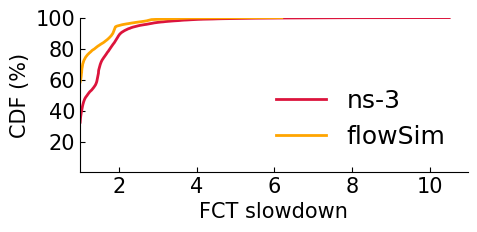

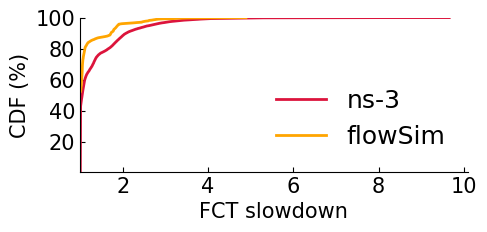

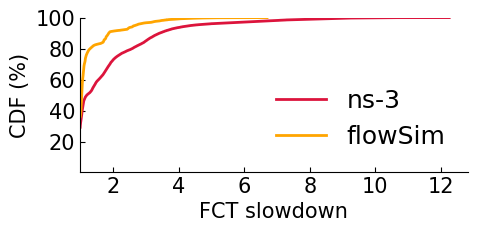

In [2]:
# size_bins = [0, 1 * 1024, 200 * 1024, 1024 * 1024, np.inf]  # Sizes in bytes
# size_bin_labels = ['<=1KB', '1KB-200KB','200KB-1MB', '1MB']
size_bins = [0, np.inf]  # Sizes in bytes
size_bin_labels = ['all']
legend_list=['ns-3','flowSim']
model_instance_list=['flowsim']
n_methods = len(legend_list)
empirical_str = f"eval_test"

fig_index=0
for scenario_idx in [60,87,21]:
    fid=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{scenario_idx}/ns3/fid_topology_flows.npy')
    sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{scenario_idx}/ns3/fsize.npy')[fid]
    
    time_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_test/{scenario_idx}/ns3/log_sim.txt'
    with open(time_file) as f:
        lines = f.readlines()
        if lines:  # Check if the file is not empty
            last_line = lines[-1]
            print("Runtime (h):", float(last_line.strip())/60)
        else:
            print("The file is empty.")
    error_list=[]
    error_size_list=[]
    for model_idx,model_instance in enumerate(model_instance_list):
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[scenario_idx, :len(sizes), 0]
        actual_sldns = sldn[scenario_idx,:len(sizes), 1]
        # print(f"waste: {np.mean(sldn[scenario_idx, len(sizes):, 0])}, {np.mean(sldn[scenario_idx, len(sizes):, 1])}")
        print(f"{model_instance}-sldn: {predicted_sldns.shape}")
        
        predicted_sldns[predicted_sldns<1]=1
        actual_sldns[actual_sldns<1]=1
        if model_idx==0:
            error_list.extend([actual_sldns,predicted_sldns])
            error_size_list.extend([sizes,sizes])
        else:
            error_list.append(predicted_sldns)
            error_size_list.append(sizes)

    # Initialize a dictionary to store errors per size bucket for each model instance
    error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

    # Process the data for each model instance
    for mi in range(n_methods):
        legend = legend_list[mi]
        errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
        sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

        # Flatten the arrays
        errors_flat = errors.flatten()
        sizes_flat = sizes.flatten()

        # Assign flows to size buckets
        size_indices = np.digitize(sizes_flat, size_bins)

        # Collect errors for each size bucket
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = errors_flat[bin_mask]
            error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

    # Plot the CDF of errors for each size bucket
    for idx, size_bin_label in enumerate(size_bin_labels):
        plot_data=[]
        for mi, legend in enumerate(legend_list):
            bin_errors = error_bins[legend][size_bin_label]
            plot_data.append(bin_errors)
        plot_data=np.array(plot_data)
        error_mean=np.mean(abs(plot_data[0]-plot_data[1])/plot_data[0])*100
        sldn_p99_gt=np.percentile(plot_data[0],99)
        sldn_p99_pred=np.percentile(plot_data[1],99)
        error_p99=abs(sldn_p99_gt-sldn_p99_pred)/sldn_p99_gt*100
        print(f"{size_bin_label}: {len(plot_data[0])}, mean: {error_mean}, p99: {error_p99} ({sldn_p99_gt} {sldn_p99_pred})")
        plot_cdf(plot_data,f'./figs/eva_pre_cdf_{idx}.pdf',legend_list if idx==0 else [],'FCT slowdown',legend_font=18,group_size=3,loc=4,rotate_xaxis=False,ylim_low=1,log_switch=False,xlim_bottom=1, fig_idx=fig_index)
        fig_index+=1

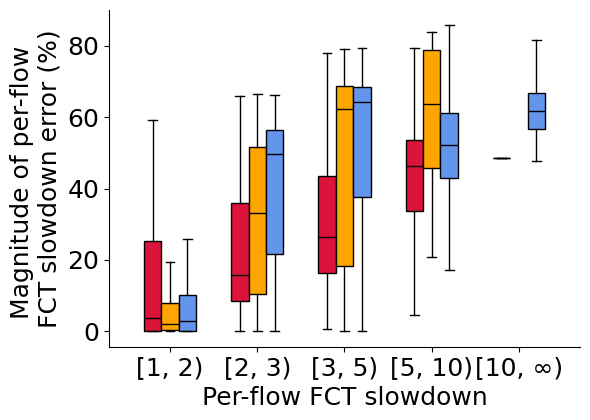

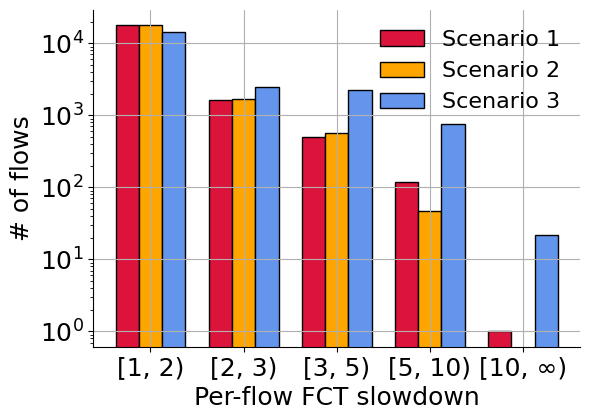

In [5]:
import numpy as np

slowdown_bins = [1, 2, 3, 5, 10, float('inf')]
slowdown_bin_labels = ['[1, 2)', '[2, 3)', '[3, 5)', '[5, 10)', '[10, ∞)']
model_instance_list = ['flowsim']
empirical_str = "eval_test"

# Initialize storage for errors and flow counts
scenario_errors = {scenario: {label: [] for label in slowdown_bin_labels} for scenario in [60, 87, 21]}
scenario_flow_counts = {scenario: {label: 0 for label in slowdown_bin_labels} for scenario in [60, 87, 21]}

# Process each scenario
for scenario_idx in [60, 87, 21]:
    sizes = np.load(
        f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{scenario_idx}/ns3/fsize.npy'
    )

    for model_instance in model_instance_list:
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[scenario_idx, :, 0]
        actual_sldns = sldn[scenario_idx, :, 1]

        predicted_sldns[predicted_sldns < 1] = 1
        actual_sldns[actual_sldns < 1] = 1

        # Calculate relative errors
        errors = abs(predicted_sldns - actual_sldns) / actual_sldns * 100
        slowdown_indices = np.digitize(actual_sldns, slowdown_bins, right=False)

        for b in range(1, len(slowdown_bins)):
            bin_mask = slowdown_indices == b
            bin_errors = errors[bin_mask]
            bin_flow_count = np.sum(bin_mask)

            scenario_errors[scenario_idx][slowdown_bin_labels[b - 1]].extend(bin_errors)
            scenario_flow_counts[scenario_idx][slowdown_bin_labels[b - 1]] += bin_flow_count


# Prepare data for plots
# Boxplot data
bucketed_data = [[scenario_errors[scenario][label] for scenario in [60, 87, 21]] for label in slowdown_bin_labels]

# Bar plot data
flow_counts = [[scenario_flow_counts[scenario][label] for scenario in [60, 87, 21]] for label in slowdown_bin_labels]
flow_counts = list(zip(*flow_counts))  # Transpose to match bar plot input format

# Plot the grouped boxplots for relative errors
plot_grouped_boxplots(
    bucketed_data=bucketed_data,
    bucket_labels=slowdown_bin_labels,
    # scenario_labels=['Scenario 1', 'Scenario 2', 'Scenario 3'],
    file_name="./figs/prev_boxplot_errors.pdf",
    # title="Relative Error Distribution by Slowdown Range Across Scenarios",
    x_label="Per-flow FCT slowdown",
    y_label="Magnitude of per-flow \nFCT slowdown error (%)",
    fontsize=18,
    legend_font=13,
    loc=2,
    fig_size=(6, 4.3),
    y_ticklabel_fontsize=18,
)

# Plot the bar chart for flow counts
plot_bars(
    data=flow_counts,
    x_labels=slowdown_bin_labels,
    file_name="./figs/prev_bar_flow_counts.pdf",
    bar_labels=['Scenario 1', 'Scenario 2', 'Scenario 3'],
    x_label="Per-flow FCT slowdown",
    y_label="# of flows",
    figsize=(6, 4.3),
    fontsize=18,
    legend_font=16,
    log_switch=True,
    loc=1,
    # title="Number of Flows by Slowdown Range Across Scenarios",
)


flowsim-sldn: (1, 85584)
final_10-sldn: (1, 85584)
final_nosize_11-sldn: (1, 85584)
final_noqueue_9-sldn: (1, 85584)


/data1/lichenni/projects/per-flow-sim/util/plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


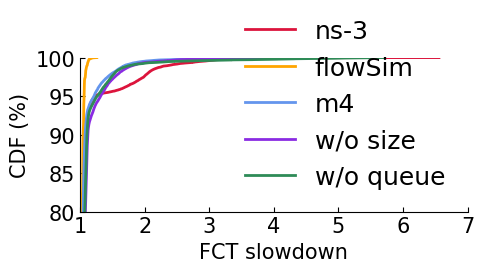

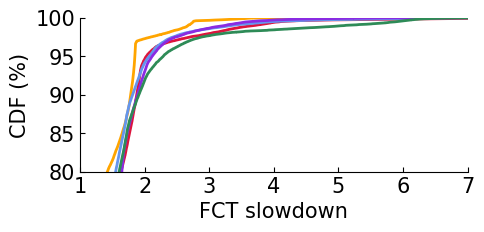

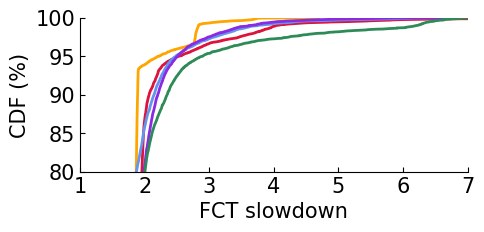

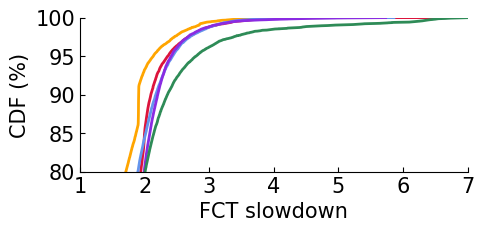

In [2]:
size_bins = [0, 1 * 1024, 200 * 1024, 1024 * 1024, np.inf]  # Sizes in bytes
size_bin_labels = ['<=1KB', '1KB-200KB','200KB-1MB', '1MB']
legend_list=['ns-3','flowSim','m4','w/o size','w/o queue']
model_instance_list=['flowsim']
n_methods = len(legend_list)
fig_index=0
for scenario_idx in [0]:
    empirical_str = f"_large{scenario_idx}"

    sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_7/data/{scenario_idx}/ns3/fsize.npy')

    error_list=[]
    error_size_list=[]
    for model_idx,model_instance in enumerate(model_instance_list):
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0]
        actual_sldns = sldn[:,:, 1]
        print(f"{model_instance}-sldn: {predicted_sldns.shape}")
        
        predicted_sldns[predicted_sldns<1]=1
        actual_sldns[actual_sldns<1]=1
        if model_idx==0:
            error_list.extend([actual_sldns,predicted_sldns])
            error_size_list.extend([sizes,sizes])
        else:
            error_list.append(predicted_sldns)
            error_size_list.append(sizes)

    # Initialize a dictionary to store errors per size bucket for each model instance
    error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

    # Process the data for each model instance
    for mi in range(n_methods):
        legend = legend_list[mi]
        errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
        sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

        # Flatten the arrays
        errors_flat = errors.flatten()
        sizes_flat = sizes.flatten()

        # Assign flows to size buckets
        size_indices = np.digitize(sizes_flat, size_bins)

        # Collect errors for each size bucket
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = errors_flat[bin_mask]
            error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

    # Plot the CDF of errors for each size bucket
    for idx, size_bin_label in enumerate(size_bin_labels):
        plot_data=[]
        for mi, legend in enumerate(legend_list):
            bin_errors = error_bins[legend][size_bin_label]
            plot_data.append(bin_errors)
        plot_cdf(plot_data,f'./figs/eva_large_scale_ablation_{idx}.pdf',legend_list if idx==0 else [],'FCT slowdown',legend_font=18,group_size=5,loc=4,rotate_xaxis=False,ylim_low=80,log_switch=False,xlim=7,xlim_bottom=1, fig_idx=fig_index)
        fig_index+=1

flowsim-sldn: (1, 85584)
final_10-sldn: (1, 85584)
final_noflowsim_12-sldn: (1, 85584)


/data1/lichenni/projects/per-flow-sim/util/plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(
/data1/lichenni/projects/per-flow-sim/util/plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(


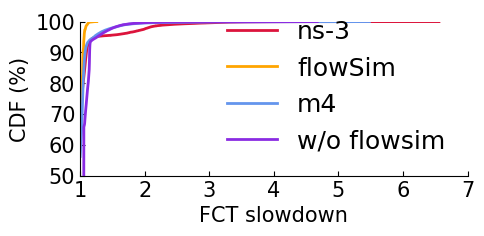

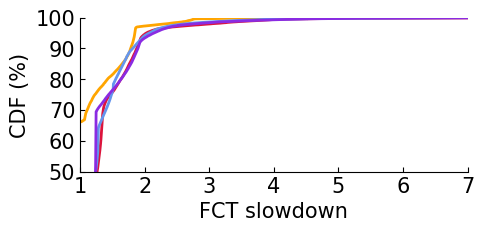

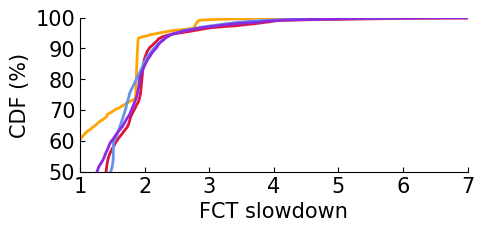

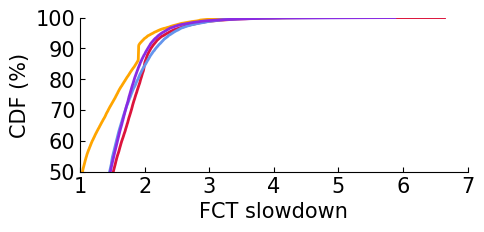

In [3]:
size_bins = [0, 1 * 1024, 200 * 1024, 1024 * 1024, np.inf]  # Sizes in bytes
size_bin_labels = ['<=1KB', '1KB-200KB','200KB-1MB', '1MB']
legend_list=['ns-3','flowSim','m4','w/o flowsim']
model_instance_list=['flowsim',"final_10",'final_noflowsim_12']
n_methods = len(legend_list)
fig_index=0
for scenario_idx in [0]:
    empirical_str = f"_large{scenario_idx}"

    sizes=np.load(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_7/data/{scenario_idx}/ns3/fsize.npy')

    error_list=[]
    error_size_list=[]
    for model_idx,model_instance in enumerate(model_instance_list):
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0]
        actual_sldns = sldn[:,:, 1]
        print(f"{model_instance}-sldn: {predicted_sldns.shape}")
        
        predicted_sldns[predicted_sldns<1]=1
        actual_sldns[actual_sldns<1]=1
        if model_idx==0:
            error_list.extend([actual_sldns,predicted_sldns])
            error_size_list.extend([sizes,sizes])
        else:
            error_list.append(predicted_sldns)
            error_size_list.append(sizes)

    # Initialize a dictionary to store errors per size bucket for each model instance
    error_bins = {legend: {label: np.array([]) for label in size_bin_labels} for legend in legend_list}

    # Process the data for each model instance
    for mi in range(n_methods):
        legend = legend_list[mi]
        errors = error_list[mi]  # Shape: (n_scenarios, n_flows)
        sizes = error_size_list[mi]  # Shape: (n_scenarios, n_flows)

        # Flatten the arrays
        errors_flat = errors.flatten()
        sizes_flat = sizes.flatten()

        # Assign flows to size buckets
        size_indices = np.digitize(sizes_flat, size_bins)

        # Collect errors for each size bucket
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = errors_flat[bin_mask]
            error_bins[legend][size_bin_labels[b - 1]] = np.concatenate((error_bins[legend][size_bin_labels[b - 1]], bin_errors))

    # Plot the CDF of errors for each size bucket
    for idx, size_bin_label in enumerate(size_bin_labels):
        plot_data=[]
        for mi, legend in enumerate(legend_list):
            bin_errors = error_bins[legend][size_bin_label]
            plot_data.append(bin_errors)
        plot_cdf(plot_data,f'./figs/eva_large_scale_ablation_{idx}.pdf',legend_list if idx==0 else [],'FCT slowdown',legend_font=18,group_size=5,loc=4,rotate_xaxis=False,ylim_low=50,log_switch=False,xlim=7,xlim_bottom=1, fig_idx=fig_index)
        fig_index+=1

-----------------
flowsim_large0-sldn: (85584,)
p99 slowdown: 2.70716249702616, 3.3371159918619004
final_10_large0-sldn: (85584,)
p99 slowdown: 3.068893063068388, 3.3371159918619004
mean error:[19.796066156243874, 7.8684682423973324]
p99 error: [18.87718306  8.03756685]
-----------------
flowsim_large1-sldn: (573200,)
p99 slowdown: 1.894515957568375, 2.726311837855774
final_10_large1-sldn: (573200,)
p99 slowdown: 2.3125627064704894, 2.726311837855774
mean error:[11.783684584416266, 7.3040776669639005]
p99 error: [30.50993172 15.17614844]
-----------------
flowsim_large2-sldn: (92278,)
p99 slowdown: 2.258125336602001, 3.245190878982736
final_10_large2-sldn: (92278,)
p99 slowdown: 2.701640210151671, 3.245190878982736
mean error:[13.06790256885921, 6.142199430141441]
p99 error: [30.41625529 16.74942058]


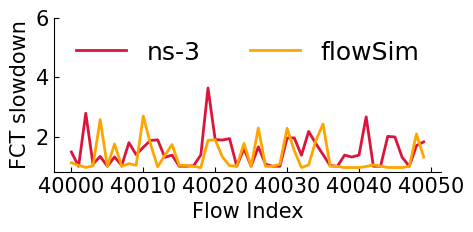

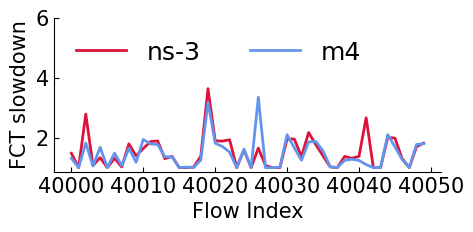

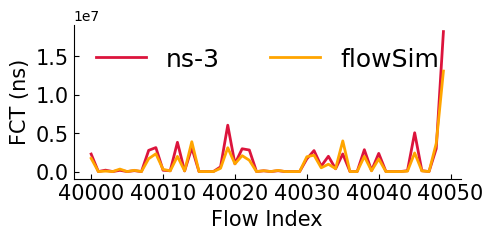

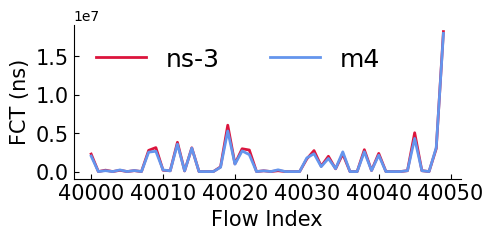

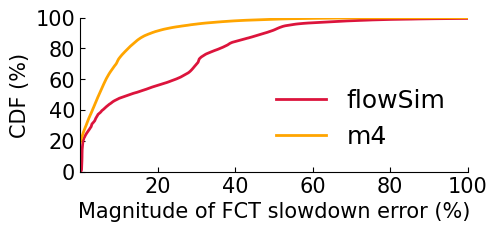

In [12]:
empirical_str = ""

legend_list=['flowSim','m4']

for scenario_idx,scenario_str in enumerate(["_large0","_large1","_large2"]):
    model_instance_list=[f'flowsim{scenario_str}',f"final_10{scenario_str}"]
                        
    error_list=[]
    error_list_p99=[]
    sldn_list=[]
    fct_list=[]
    print(f"-----------------")
    for model_instance in model_instance_list:
        data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
        sldn = data_m4['sldn']
        predicted_sldns = sldn[:, :, 0].squeeze()
        actual_sldns = sldn[:,:, 1].squeeze()
        print(f"{model_instance}-sldn: {predicted_sldns.shape}")
        
        fct=data_m4['fct']
        predicted_fcts = fct[:, :, 0].squeeze()
        actual_fcts = fct[:,:, 1].squeeze()
        
        predicted_sldns[predicted_sldns==0]=1
        actual_sldns[actual_sldns==0]=1
        # calculate the relative error
        relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
        sldn_list.append([actual_sldns,predicted_sldns])
        fct_list.append([actual_fcts,predicted_fcts])
        error_list.append(relative_error_sldn)
        
        sldn_p99_est=np.percentile(predicted_sldns,99)
        sldn_p99_act=np.percentile(actual_sldns,99)
        print(f"p99 slowdown: {sldn_p99_est}, {sldn_p99_act}")
        error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
    error_list=np.array(error_list)
    error_list_p99=np.array(error_list_p99)
    sldn_list=np.array(sldn_list)
    fct_list=np.array(fct_list)
    print(f"mean error:{[np.mean(x) for x in error_list]}")
    print(f"p99 error: {error_list_p99}")
    
    if scenario_idx==0:  
        fig_idx=0
        data_x=np.arange(40000, 40050)
        linelabels = [["ns-3","flowSim"],["ns-3","m4"]]
        format_idx=[[0,1],[0,2]]
        for i, (actual, predicted) in enumerate(sldn_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                f'./figs/eva_large_scale_line_sldn_{i}.pdf',
                linelabels[i],
                x_label="Flow Index",
                y_label="FCT slowdown",
                title=None,
                ylim=6,
                format_idx=format_idx[i],
                legend_cols=2,
                legend_font=18,
                fig_idx=fig_idx,
            )
            fig_idx+=1

        for i, (actual, predicted) in enumerate(fct_list):
            plot_data=[(data_x,actual[data_x]),(data_x,predicted[data_x])]
            plot_lines(
                plot_data,
                f'./figs/eva_large_scale_line_fct_{i}.pdf',
                linelabels[i],
                x_label="Flow Index",
                y_label="FCT (ns)",
                title=None,
                # log_switch=True,
                # ylim=6,
                format_idx=format_idx[i],
                legend_cols=2,
                legend_font=18,
                fig_idx=fig_idx,
            )
            fig_idx+=1
            
        plot_cdf(
            error_list,
            f'./figs/eva_large_scale_cdf.pdf',
            legend_list,
            x_label="Magnitude of FCT slowdown error (%)",
            log_switch=False,
            rotate_xaxis=False,
            xlim=100,
            xlim_bottom=0.01,
            fontsize=15,
            legend_font=18,
            loc=4,
            enable_abs=True,
            group_size=5,
            fig_idx=fig_idx
        )

flowsim-sldn: (100, 80000)
final_10-sldn: (100, 80000)
final_re_10-sldn: (100, 80000)
final_re_7-sldn: (100, 80000)
p99 error:[51.318473578274116, 30.861910103016758, 33.62048997305871, 33.082686511095254]
mean error:[19.992697597582136, 11.847883297628956, 12.356828564005239, 12.605645367512018]
median error:[18.238018190723377, 10.19377302745006, 10.649606155491679, 10.618592128026908]
p99 error:[23.874223952716665, 8.662522686805126, 12.460835535030713, 14.401865726308982]


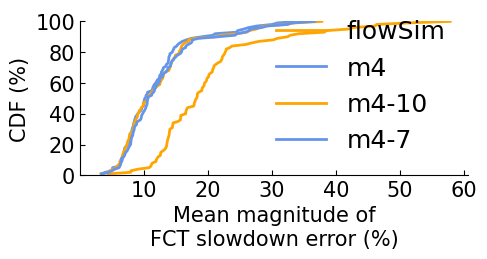

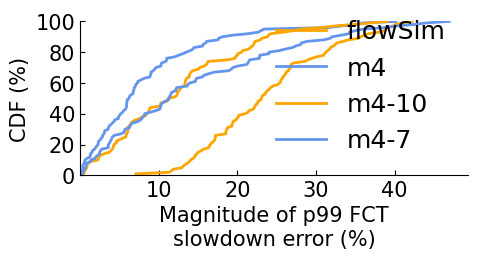

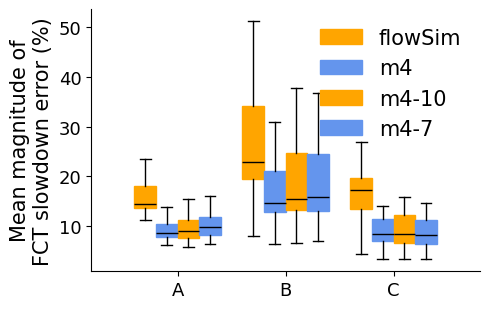

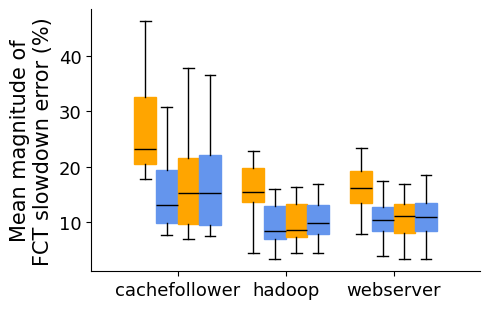

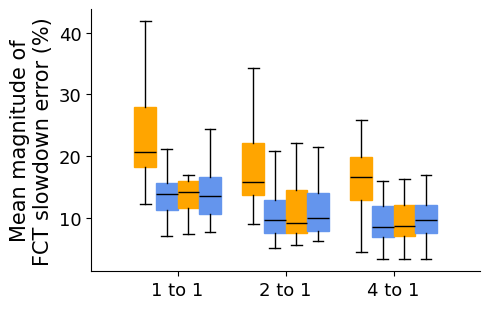

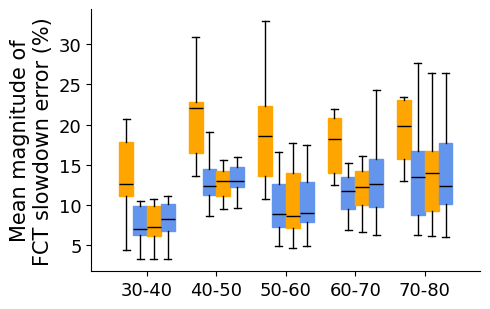

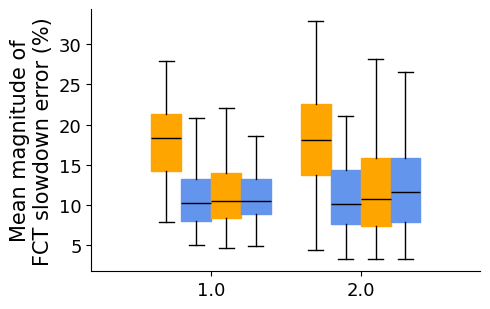

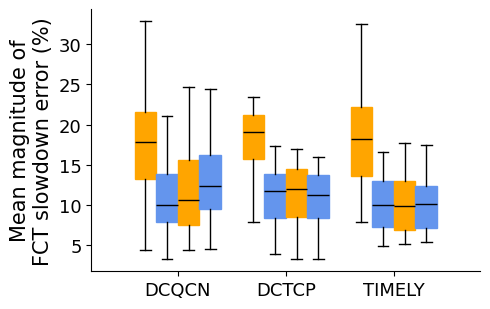

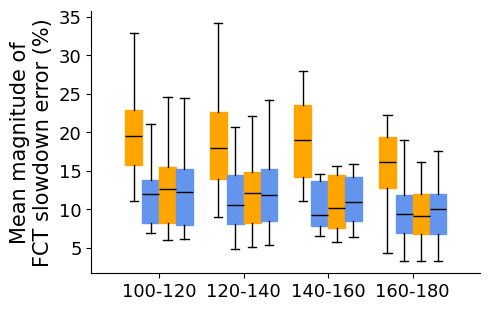

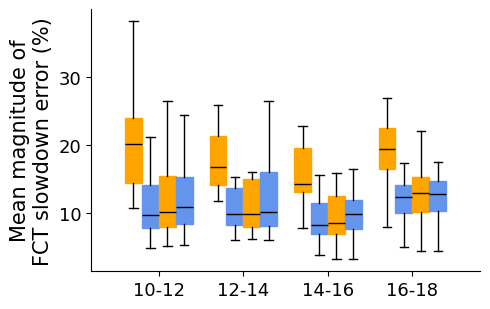

In [2]:
n_scenario=100
empirical_str = "eval_test"
legend_list=['flowSim','m4','m4-10','m4-7']
model_instance_list=['flowsim','final_10','final_re_10','final_re_7']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    # if spatial!="cluster_c_4_16":
    # if size_dist!='webserver-all':
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_cdf_mean.pdf",
    legend_list,
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
)
fig_idx+=1

plot_cdf(
    error_list_p99,
    f"./figs/eva_cdf_p99.pdf",
    legend_list,
    x_label="Magnitude of p99 FCT\nslowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue"],
    fig_idx=fig_idx,
)
fig_idx+=1

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3, 0.4,0.5, 0.6, 0.7, 0.8]
labels = ['30-40', '40-50', '50-60', '60-70', '70-80']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bfsz_values=bfsz_values*10
bins = [100,120,140,160,180]
labels = ['100-120', '120-140', '140-160', '160-180']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [10000,12000,14000,16000,18000]
labels = ['10-12', '12-14', '14-16', '16-18']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)

# Generate plots for each configuration attribute
config_attributes = ["Traffic matrix", "Flow size distribution", "Oversubscription", "Max load (%)", "Burstiness (log-normal's $\sigma$)", "Congestion control algorithm", "Buffer size (KB)", "Init. window size (KB)"]
error_list=error_list.T
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list, legend_list if i==0 else None,n_methods=len(legend_list),config_list=config_list, config_index=i, config_name=config_name,fig_idx=fig_idx,loc=1,file_name=f"figs/eva_box_{i}.pdf",y_label="Mean magnitude of\nFCT slowdown error (%)")
    fig_idx+=1

flowsim-sldn: (100, 80000)
final_10-sldn: (100, 80000)
final_nosize_11-sldn: (100, 80000)
final_noqueue_9-sldn: (100, 80000)
final_noflowsim_12-sldn: (100, 80000)
p99 error:[51.318473578274116, 30.861910103016758, 35.164010448076546, 44.356283291556814, 28.26527410080026]
mean error:[19.992697597582136, 11.847883297628956, 14.000576128718707, 15.259909862755793, 13.056905222610979]
median error:[18.238018190723377, 10.19377302745006, 12.53077051800835, 13.09215816283924, 11.701028835434784]
p99 error:[23.874223952716665, 8.662522686805126, 13.429644007688143, 19.28207145077418, 8.786663919207697]


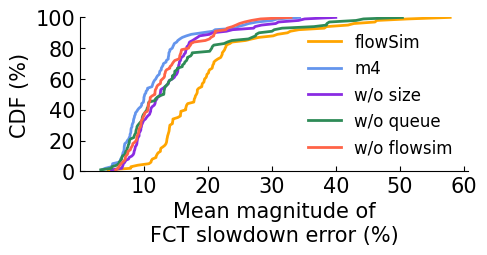

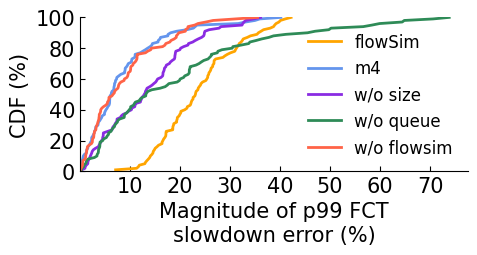

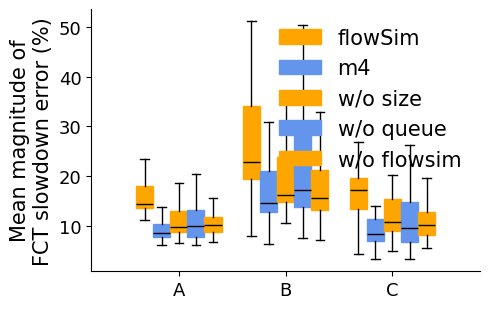

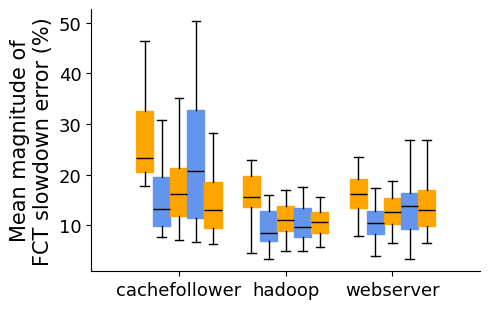

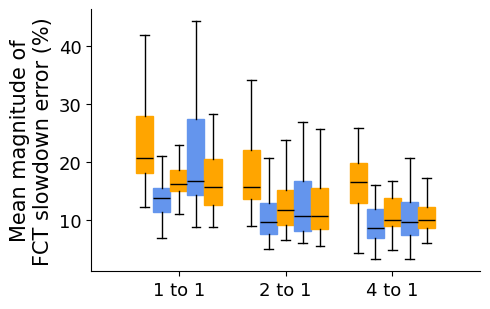

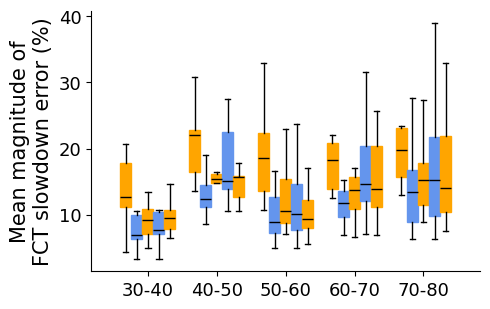

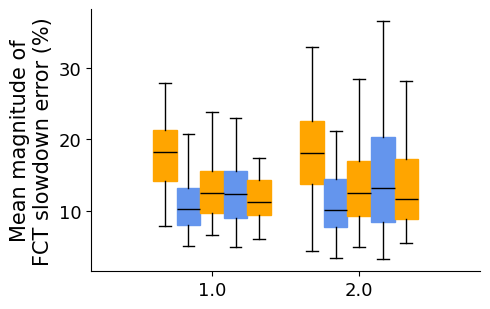

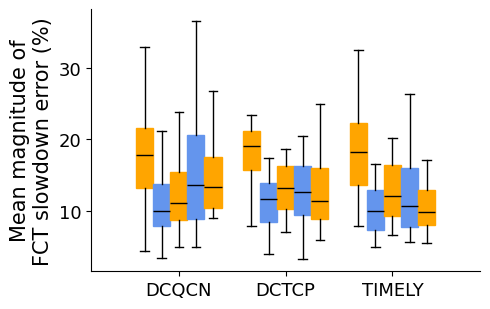

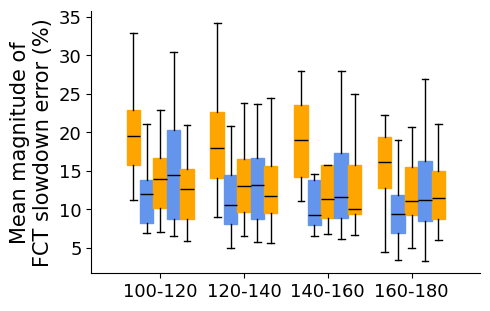

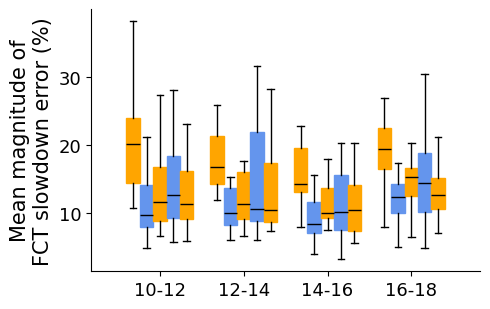

In [10]:
n_scenario=100
empirical_str = "eval_test"
# legend_list=['flowSim','m4','m4_nosupervision','m4_nosize','m4_noqueue']
# model_instance_list=['flowsim','m4_10','final_nosupervision_12','final_nosize_11','final_noqueue_9']
legend_list=['flowSim','m4','w/o size','w/o queue','w/o flowsim']
model_instance_list=['flowsim','final_10','final_nosize_11','final_noqueue_9','final_noflowsim_12']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0].split('_')[1].upper()
    size_dist=config['size_dist'].split('/')[-1].split('.')[0].split('-')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0].split('_')
    cluster=f"{cluster[1]} to {cluster[3]}"
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc'].upper()
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

fig_idx=0
plot_cdf(
    error_list,
    f"./figs/eva_ablation_mean.pdf",
    legend_list,
    x_label="Mean magnitude of\nFCT slowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato'],
    fig_idx=fig_idx,
)
fig_idx+=1

plot_cdf(
    error_list_p99,
    f"./figs/eva_ablation_p99.pdf",
    legend_list,
    x_label="Magnitude of p99 FCT\nslowdown error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    colors=["orange",
    "cornflowerblue",
    "blueviolet",
    "seagreen",
    'tomato'],
    fig_idx=fig_idx,
)
fig_idx+=1

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3, 0.4,0.5, 0.6, 0.7, 0.8]
labels = ['30-40', '40-50', '50-60', '60-70', '70-80']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bfsz_values=bfsz_values*10
bins = [100,120,140,160,180]
labels = ['100-120', '120-140', '140-160', '160-180']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [10000,12000,14000,16000,18000]
labels = ['10-12', '12-14', '14-16', '16-18']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)

# Generate plots for each configuration attribute
config_attributes = ["Traffic matrix", "Flow size distribution", "Oversubscription", "Max load (%)", "Burstiness (log-normal's $\sigma$)", "Congestion control algorithm", "Buffer size (KB)", "Init. window size (KB)"]
error_list=error_list.T
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list, legend_list if i==0 else None,n_methods=len(legend_list),config_list=config_list, config_index=i, config_name=config_name,fig_idx=fig_idx,loc=1,file_name=None,y_label="Mean magnitude of\nFCT slowdown error (%)")
    fig_idx+=1

n_data: 400
res_size_list: (2, 1406468)
res_queue_list: (2, 76734)
res_size_list: (2, 1406468), max: 100.0, min: 0.001284387173008787
res_queue_list: (2, 76734) 340.0 0.0
mean error size: 19.82445955461523, median error size: 16.03656297623137
mean error queue: 2.397422156550006, median error queue: 2.39168311964022e-05


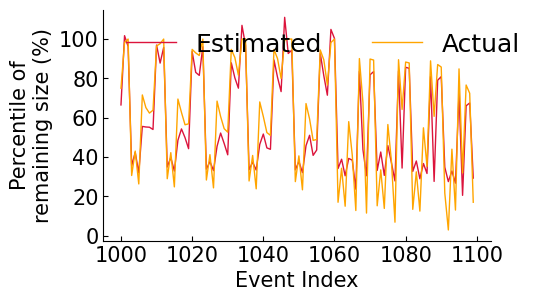

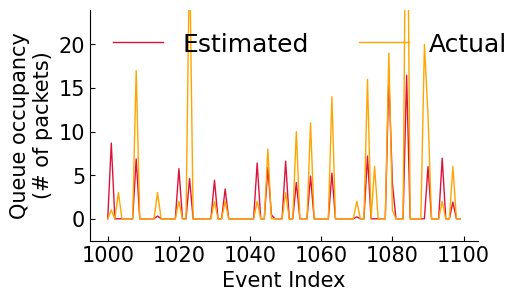

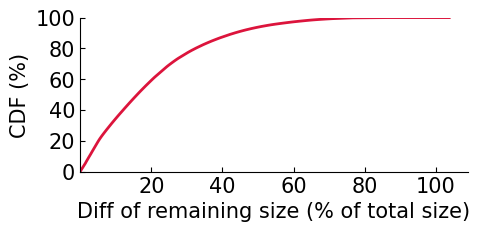

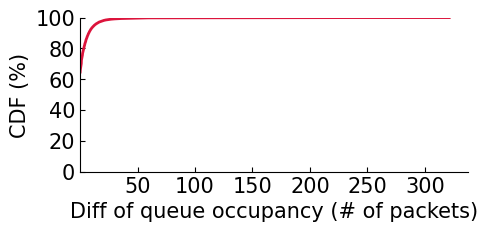

In [13]:
res_dir='/data2/lichenni/output_perflow/final_shard4000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/test/version_0'
data_file='/data2/lichenni/output_perflow/final_shard4000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/data_list.json'
data_list=json.load(open(data_file))['test']
print(f"n_data: {len(data_list)}")

res_size_list=[]
res_queue_list=[]
for (spec, src_dst_pair_target, topo_type, segment_id, _) in data_list:
    dir_tmp=f'{res_dir}/{spec}_topology_flows_0_31_seg{segment_id}'
    npz_file=f'{dir_tmp}/res.npz'
    res=np.load(npz_file)
    res_size=res['res_size']*100
    res_size_list.append(res_size)
    res_queue=res['res_queue']
    res_queue_list.append(res_queue)
res_size_list=np.concatenate(res_size_list,axis=1)
res_queue_list=np.concatenate(res_queue_list,axis=1)
print(f"res_size_list: {res_size_list.shape}")
print(f"res_queue_list: {res_queue_list.shape}")
# mask=res_size_list[1]==0
# res_size_list[:,mask]+=1
# mask=res_queue_list[1]==0
# res_queue_list[:,mask]+=1
print(f"res_size_list: {res_size_list.shape}, max: {np.max(res_size_list[1])}, min: {np.min(res_size_list[1])}")
print(f"res_queue_list: {res_queue_list.shape}", np.max(res_queue_list[1]), np.min(res_queue_list[1]))
error_size=abs(res_size_list[0]-res_size_list[1])
print(f"mean error size: {np.mean(error_size)}, median error size: {np.median(error_size)}")
error_queue=abs(res_queue_list[0]-res_queue_list[1])
print(f"mean error queue: {np.mean(error_queue)}, median error queue: {np.median(error_queue)}")

fig_idx=0
data_x=np.arange(1000, 1100)
plot_data=[(data_x,res_size_list[0,data_x]),(data_x,res_size_list[1,data_x])]
plot_lines(
    plot_data,
    # f'./figs/eva_large_scale_line_fct_{i}.pdf',
    None,
    ['Estimated','Actual'],
    x_label="Event Index",
    y_label="Percentage of\nremaining size (%)",
    title=None,
    # log_switch=True,
    ylim=115,
    format_idx=[0,1],
    legend_cols=2,
    legend_font=18,
    fig_idx=fig_idx,
    linewidth=1,
    fig_size=(5,3)
)
fig_idx+=1

# data_x=np.arange(0, res_queue_list.shape[1])
data_x=np.arange(1000, 1100)
plot_data=[(data_x,res_queue_list[0,data_x]),(data_x,res_queue_list[1,data_x])]
plot_lines(
    plot_data,
    # f'./figs/eva_large_scale_line_fct_{i}.pdf',
    None,
    ['Estimated','Actual'],
    x_label="Event Index",
    y_label="Queue occupancy\n(# of packets)",
    title=None,
    # log_switch=True,
    ylim=24,
    format_idx=[0,1],
    legend_cols=2,
    legend_font=18,
    fig_idx=fig_idx,
    linewidth=1,
    fig_size=(5,3)
)
fig_idx+=1
            
plot_cdf(
    [error_size],
    # f'./figs/eva_large_scale_cdf.pdf',
    None,
    [],
    x_label="Diff of remaining size (% of total size)",
    log_switch=False,
    rotate_xaxis=False,
    # xlim=100,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_idx
)
fig_idx+=1
            
plot_cdf(
    [error_queue],
    # f'./figs/eva_large_scale_cdf.pdf',
    None,
    [],
    x_label="Diff of queue occupancy (# of packets)",
    log_switch=False,
    rotate_xaxis=False,
    # xlim=100,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_idx
)


max_idx: 835
max_idx: 327
res_size_plot: (2, 8293)
res_queue_plot: (2, 1616)
res_size_list: (2, 14062)
res_queue_list: (2, 3472)
res_size_list: (2, 14062), max: 100.0, min: 0.008783797286689666
res_queue_list: (2, 3472) 281.0 0.0
mean error size: 17.60779343348872, median error size: 13.583475999554697
mean error queue: 2.2633043967435142, median error queue: 2.39168311964022e-05


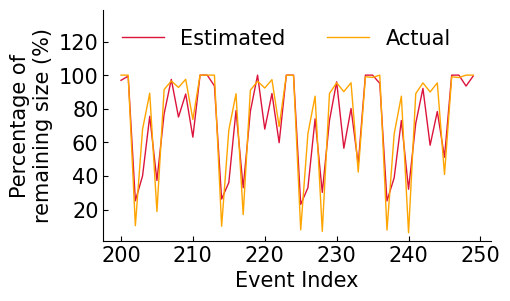

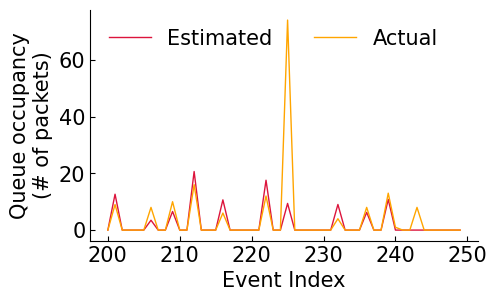

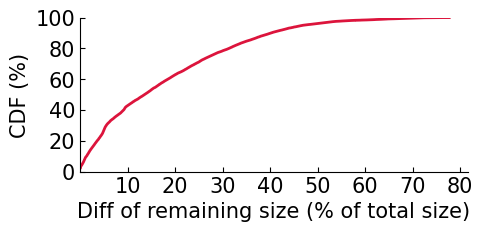

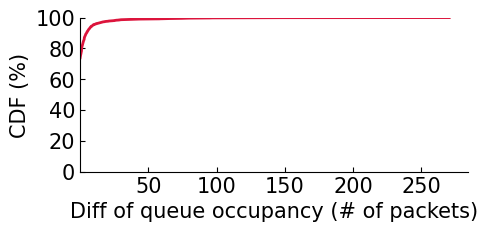

In [62]:
res_dir='/data2/lichenni/output_perflow/final_shard4000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/test/version_4'

res_size_list=[]
res_queue_list=[]
for scenario_idx in range(100):
    if os.path.exists(f'{res_dir}/{scenario_idx}'):
        dir_list=os.listdir(f'{res_dir}/{scenario_idx}')
        for dir_tmp in dir_list:
            npz_file=f'{res_dir}/{scenario_idx}/{dir_tmp}/res.npz'
            res=np.load(npz_file)
            res_size=res['res_size']*100
            res_size[res_size>100]=100
            res_size_list.append(res_size)
            res_queue=res['res_queue']
            res_queue_list.append(res_queue)
len_queue=[x.shape[1] for x in res_size_list]
max_idx=np.argmax(len_queue)
print(f"max_idx: {max_idx}")
res_size_plot=res_size_list[max_idx]
len_queue=[x.shape[1] for x in res_queue_list]
max_idx=np.argmax(len_queue)
print(f"max_idx: {max_idx}")
res_queue_plot=res_queue_list[max_idx]
print(f"res_size_plot: {res_size_plot.shape}")
print(f"res_queue_plot: {res_queue_plot.shape}")

res_size_list=np.concatenate(res_size_list,axis=1)
res_queue_list=np.concatenate(res_queue_list,axis=1)
print(f"res_size_list: {res_size_list.shape}")
print(f"res_queue_list: {res_queue_list.shape}")
# mask=res_size_list[1]==0
# res_size_list[:,mask]+=1
# mask=res_queue_list[1]==0
# res_queue_list[:,mask]+=1
print(f"res_size_list: {res_size_list.shape}, max: {np.max(res_size_list[1])}, min: {np.min(res_size_list[1])}")
print(f"res_queue_list: {res_queue_list.shape}", np.max(res_queue_list[1]), np.min(res_queue_list[1]))
error_size=abs(res_size_list[0]-res_size_list[1])
print(f"mean error size: {np.mean(error_size)}, median error size: {np.median(error_size)}")
error_queue=abs(res_queue_list[0]-res_queue_list[1])
print(f"mean error queue: {np.mean(error_queue)}, median error queue: {np.median(error_queue)}")

fig_idx=0
data_x=np.arange(200,250)
plot_data=[(data_x,res_size_plot[0,data_x]),(data_x,res_size_plot[1,data_x])]
plot_lines(
    plot_data,
    # f'./figs/eva_large_scale_line_fct_{i}.pdf',
    None,
    ['Estimated','Actual'],
    x_label="Event Index",
    y_label="Percentage of\nremaining size (%)",
    title=None,
    # log_switch=True,
    ylim=139,
    format_idx=[0,1],
    legend_cols=2,
    legend_font=15,
    fig_idx=fig_idx,
    linewidth=1,
    fig_size=(5,3)
)
fig_idx+=1

# data_x=np.arange(0, res_queue_list.shape[1])
data_x=np.arange(200,250)
plot_data=[(data_x,res_queue_plot[0,data_x]),(data_x,res_queue_plot[1,data_x])]
plot_lines(
    plot_data,
    # f'./figs/eva_large_scale_line_fct_{i}.pdf',
    None,
    ['Estimated','Actual'],
    x_label="Event Index",
    y_label="Queue occupancy\n(# of packets)",
    title=None,
    # log_switch=True,
    # ylim=24,
    format_idx=[0,1],
    legend_cols=2,
    legend_font=15,
    fig_idx=fig_idx,
    linewidth=1,
    fig_size=(5,3)
)
fig_idx+=1
            
plot_cdf(
    [error_size],
    # f'./figs/eva_large_scale_cdf.pdf',
    None,
    [],
    x_label="Diff of remaining size (% of total size)",
    log_switch=False,
    rotate_xaxis=False,
    # xlim=100,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_idx
)
fig_idx+=1
            
plot_cdf(
    [error_queue],
    # f'./figs/eva_large_scale_cdf.pdf',
    None,
    [],
    x_label="Diff of queue occupancy (# of packets)",
    log_switch=False,
    rotate_xaxis=False,
    # xlim=100,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_idx
)


max_idx: 1427
max_idx: 152
res_size_plot: (2, 49)
res_queue_plot: (2, 108)
error_queue_list: (3472,), mean: 2.2632951418633036, median: 2.39168311964022e-05
error_size_list: (2084,), mean: 6.314991674805736, median: 5.060982704162598
size_list: (2084,), max: 90843.84375, min: 0.004999995231628418
pkt_list: (3472,), max: 281.0, min: 0.0


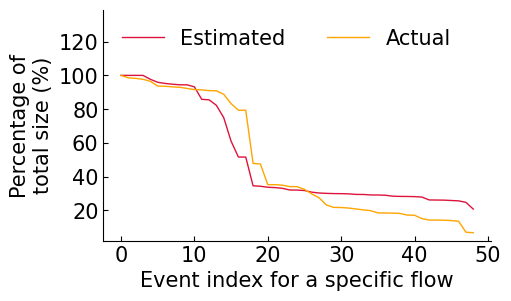

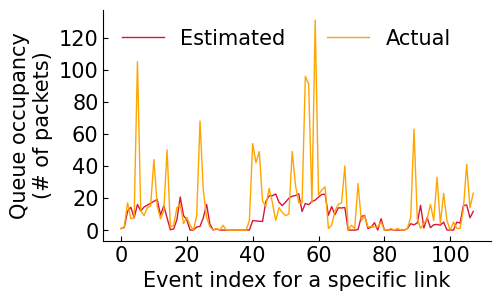

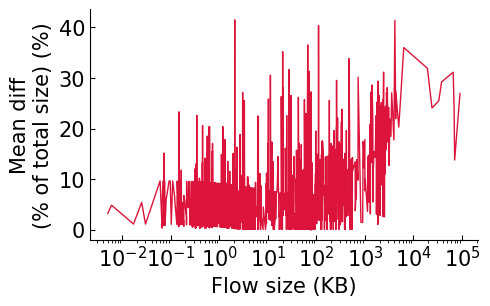

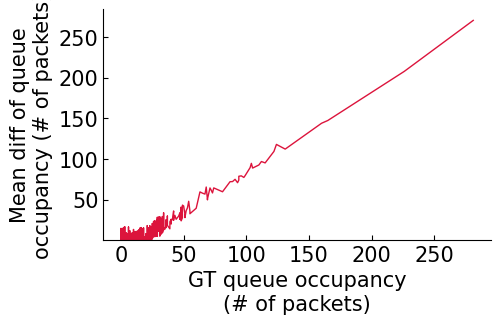

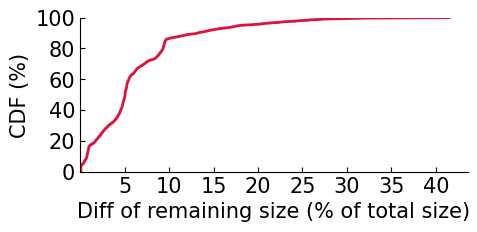

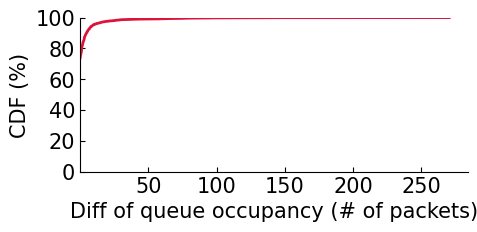

In [13]:
res_dir='/data2/lichenni/output_perflow/final_shard4000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/test/version_6'

res_size_perflow=[]
res_queue_perlink=[]
error_size_list=[]
size_list=[]
error_queue_list=[]
pkt_list=[]
for scenario_idx in range(100):
    if os.path.exists(f'{res_dir}/{scenario_idx}'):
        
        dir_list=os.listdir(f'{res_dir}/{scenario_idx}')
        for dir_tmp in dir_list:
            res_size_dict=defaultdict(list)
            res_queue_dict=defaultdict(list)
            npz_file=f'{res_dir}/{scenario_idx}/{dir_tmp}/res.npz'
            res=np.load(npz_file)
            res_size=res['res_size'][:2]*100
            res_size[res_size>100]=100
            size_info=(np.exp2(res['size_info'])-1)
            
            res_size_flowidx=res['res_size'][2].astype(int)
            for i in range(res_size.shape[1]):
                res_size_dict[res_size_flowidx[i]].append(res_size[:2,i])
            
            for flowidx in res_size_dict:
                tmp=np.array(res_size_dict[flowidx]).T
                error=np.mean(abs(tmp[0]-tmp[1]))
                error_size_list.append(error)
                size_list.append(size_info[flowidx])
            
            res_queue=res['res_queue'][:2]
            res_queue_linkidx=res['res_queue'][2]
            for i in range(res_queue.shape[1]):
                res_queue_dict[res_queue_linkidx[i]].append(res_queue[:2,i])
                pkt_list.append(res_queue[1,i])
                error_queue_list.append(abs(res_queue[0,i]-res_queue[1,i]))
            res_size_perflow.extend(list(res_size_dict.values()))
            res_queue_perlink.extend(list(res_queue_dict.values()))
            
            # for linkidx in res_queue_dict:
            #     tmp=np.array(res_queue_dict[linkidx]).T
            #     if np.mean(tmp[1])>=1:
            #         print(f"tmp: {tmp.shape}, {np.mean(tmp[0])}, {np.mean(tmp[1])}")
            #         error=np.mean(abs(tmp[0]-tmp[1]))/np.mean(tmp[1])*100
            #         error_queue_list.append(error)
            #         pkt_list.append(np.mean(tmp[1]))
                
            
len_queue=[len(x) for x in res_size_perflow]
sorted_idx=np.argsort(len_queue)
max_idx=sorted_idx[-70]#15,40,70
print(f"max_idx: {max_idx}")
res_size_plot=np.array(res_size_perflow[max_idx]).T
res_size_plot[0]=np.sort(res_size_plot[0])[::-1]

len_queue=[len(x) for x in res_queue_perlink]
sorted_idx=np.argsort(len_queue)
max_idx=sorted_idx[-1]
print(f"max_idx: {max_idx}")
res_queue_plot=np.array(res_queue_perlink[max_idx]).T
print(f"res_size_plot: {res_size_plot.shape}")
print(f"res_queue_plot: {res_queue_plot.shape}")

error_queue_list=np.array(error_queue_list)
error_size_list=np.array(error_size_list)
print(f"error_queue_list: {error_queue_list.shape}, mean: {np.mean(error_queue_list)}, median: {np.median(error_queue_list)}")
print(f"error_size_list: {error_size_list.shape}, mean: {np.mean(error_size_list)}, median: {np.median(error_size_list)}")

size_list=np.array(size_list)
pkt_list=np.array(pkt_list)
print(f"size_list: {size_list.shape}, max: {np.max(size_list)}, min: {np.min(size_list)}")
print(f"pkt_list: {pkt_list.shape}, max: {np.max(pkt_list)}, min: {np.min(pkt_list)}")

fig_idx=0
data_x=np.arange(0,res_size_plot.shape[1])
plot_data=[(data_x,res_size_plot[0,data_x]),(data_x,res_size_plot[1,data_x])]
plot_lines(
    plot_data,
    # f'./figs/eva_large_scale_line_fct_{i}.pdf',
    None,
    ['Estimated','Actual'],
    x_label="Event index for a specific flow",
    y_label="Percentage of\ntotal size (%)",
    title=None,
    # log_switch=True,
    ylim=139,
    format_idx=[0,1],
    legend_cols=2,
    legend_font=15,
    fig_idx=fig_idx,
    linewidth=1,
    fig_size=(5,3)
)
fig_idx+=1

data_x=np.arange(0, res_queue_plot.shape[1])
plot_data=[(data_x,res_queue_plot[0,data_x]),(data_x,res_queue_plot[1,data_x])]
plot_lines(
    plot_data,
    # f'./figs/eva_large_scale_line_fct_{i}.pdf',
    None,
    ['Estimated','Actual'],
    x_label="Event index for a specific link",
    y_label="Queue occupancy\n(# of packets)",
    title=None,
    # log_switch=True,
    # ylim=24,
    format_idx=[0,1],
    legend_cols=2,
    legend_font=15,
    fig_idx=fig_idx,
    linewidth=1,
    fig_size=(5,3)
)

fig_idx+=1
sorted_indx=np.argsort(size_list)
data_x=size_list
plot_data=[(data_x[sorted_indx],error_size_list[sorted_indx])]
plot_lines(
    plot_data,
    # f'./figs/eva_large_scale_line_fct_{i}.pdf',
    None,
    [],
    x_label="Flow size (KB)",
    y_label="Mean diff\n(% of total size) (%)",
    title=None,
    # log_switch=True,
    log_switch_x=True,
    # ylim=139,
    format_idx=[0,1],
    legend_cols=2,
    legend_font=15,
    fig_idx=fig_idx,
    linewidth=1,
    fig_size=(5,3)
)
fig_idx+=1

sorted_indx=np.argsort(pkt_list)
data_x=pkt_list
plot_data=[(data_x[sorted_indx],error_queue_list[sorted_indx])]
plot_lines(
    plot_data,
    # f'./figs/eva_large_scale_line_fct_{i}.pdf',
    None,
    [],
    x_label="GT queue occupancy\n(# of packets)",
    y_label="Mean diff of queue\noccupancy (# of packets)",
    title=None,
    # log_switch_x=True,
    # log_switch=True,
    # ylim=24,
    ylim_bottom=0.1,
    format_idx=[0,1],
    legend_cols=2,
    legend_font=15,
    fig_idx=fig_idx,
    linewidth=1,
    fig_size=(5,3)
)

fig_idx+=1
plot_cdf(
    [error_size_list],
    # f'./figs/eva_large_scale_cdf.pdf',
    None,
    [],
    x_label="Diff of remaining size (% of total size)",
    log_switch=False,
    rotate_xaxis=False,
    # xlim=100,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_idx
)
fig_idx+=1
            
plot_cdf(
    [error_queue_list],
    # f'./figs/eva_large_scale_cdf.pdf',
    None,
    [],
    x_label="Diff of queue occupancy (# of packets)",
    log_switch=False,
    rotate_xaxis=False,
    # xlim=100,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=18,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_idx
)

In [6]:
# Define constants
n_scenario = 100
empirical_str = "eval_test"
legend_list = ["flowSim", "m4"]
model_instance_list = ["flowsim", "final_10"]

n_methods = len(legend_list)

# Load configurations
config_file = f"/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json"
configs = json.load(open(config_file))

# Find available scenarios
index_list_ori = []
for i in range(n_scenario):
    if os.path.exists(
        f"/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy"
    ):
        index_list_ori.append(i)

# Prepare config_list
index_list = []
config_list = []
for idx, i in enumerate(index_list_ori):
    config = configs[i]
    max_load = float(config["max_load"])
    cc = config["cc"]  # Congestion control algorithm
    config_list.append([max_load, cc])  # Include max_load and cc
    index_list.append(idx)
config_list = np.array(config_list)

# Define flow size buckets and labels
size_bins = [0, 1 * 1000, 10 * 1000, 50 * 1000, np.inf]  # Sizes in bytes
size_bin_labels = ["<=1KB", "1KB-10KB", "10KB-50KB", ">50KB"]

# Define max load groups
max_load_bins = [0, 0.50, np.inf]
max_load_labels = ["<50%", ">50%"]

# Initialize error storage
error_by_model = {
    model: {
        cc: {load: {label: [] for label in size_bin_labels} for load in max_load_labels}
        for cc in set(config_list[:, 1])
    }
    for model in legend_list
}

# Process scenarios
for idx, scenario_idx in enumerate(index_list):
    # Load flow sizes
    sizes = np.load(
        f"/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{scenario_idx}/ns3/fsize.npy"
    )

    # Flatten sizes to match dimensions with relative errors
    sizes = sizes.flatten()

    # Group flows into size buckets
    size_indices = np.digitize(sizes, size_bins)

    # Get max load and CC group for the scenario
    max_load = config_list[idx, 0]
    cc = config_list[idx, 1]
    load_group = max_load_labels[np.digitize(max_load, max_load_bins, right=False) - 1]

    # Process each model instance
    for model_idx, model_instance in enumerate(model_instance_list):
        model_name = legend_list[model_idx]
        data = np.load(f"./res/{model_instance}{empirical_str}.npz")
        sldn = data["fct"]
        predicted_sldns = sldn[scenario_idx, : len(sizes), 0]
        actual_sldns = sldn[scenario_idx, : len(sizes), 1]

        # Calculate relative errors
        relative_errors = np.abs(actual_sldns - predicted_sldns) / actual_sldns * 100

        # Flatten relative_errors to match sizes
        relative_errors = relative_errors.flatten()

        # Group errors into buckets
        for b in range(1, len(size_bins)):
            bin_mask = size_indices == b
            bin_errors = relative_errors[bin_mask]
            error_by_model[model_name][cc][load_group][size_bin_labels[b - 1]].extend(
                bin_errors
            )

# Calculate mean error for each model, CC, max load group, and size bucket
mean_error_results = {
    model: {
        cc: {
            load: {
                bucket: np.mean(errors) if errors else 0
                for bucket, errors in group.items()
            }
            for load, group in load_group_dict.items()
        }
        for cc, load_group_dict in cc_group_dict.items()
    }
    for model, cc_group_dict in error_by_model.items()
}

num_results = {
    model: {
        cc: {
            load: {bucket: len(errors) for bucket, errors in group.items()}
            for load, group in load_group_dict.items()
        }
        for cc, load_group_dict in cc_group_dict.items()
    }
    for model, cc_group_dict in error_by_model.items()
}

# Print results
print("Mean Error by Model, CC, Load Group, and Flow Size Bucket:")
for model, cc_group_dict in mean_error_results.items():
    print(f"\nModel: {model}")
    for cc, load_group_dict in cc_group_dict.items():
        print(f"  Congestion Control: {cc}")
        for load, group in load_group_dict.items():
            print(f"    Load Group: {load}")
            for bucket, mean_error in group.items():
                print(f"      {bucket}: {mean_error:.2f}%")

print("Num of Results by Model, CC, Load Group, and Flow Size Bucket:")
for model, cc_group_dict in num_results.items():
    print(f"\nModel: {model}")
    for cc, load_group_dict in cc_group_dict.items():
        print(f"  Congestion Control: {cc}")
        for load, group in load_group_dict.items():
            print(f"    Load Group: {load}")
            for bucket, num in group.items():
                print(f"      {bucket}: {num}")


Mean Error by Model, CC, Load Group, and Flow Size Bucket:

Model: flowSim
  Congestion Control: timely
    Load Group: <50%
      <=1KB: 9.79%
      1KB-10KB: 13.71%
      10KB-50KB: 28.68%
      >50KB: 34.90%
    Load Group: >50%
      <=1KB: 9.26%
      1KB-10KB: 13.43%
      10KB-50KB: 31.03%
      >50KB: 37.52%
  Congestion Control: dctcp
    Load Group: <50%
      <=1KB: 8.06%
      1KB-10KB: 11.40%
      10KB-50KB: 27.82%
      >50KB: 32.22%
    Load Group: >50%
      <=1KB: 13.40%
      1KB-10KB: 16.34%
      10KB-50KB: 36.81%
      >50KB: 44.04%
  Congestion Control: dcqcn
    Load Group: <50%
      <=1KB: 4.77%
      1KB-10KB: 8.99%
      10KB-50KB: 26.14%
      >50KB: 35.64%
    Load Group: >50%
      <=1KB: 8.94%
      1KB-10KB: 13.22%
      10KB-50KB: 33.20%
      >50KB: 41.69%

Model: m4
  Congestion Control: timely
    Load Group: <50%
      <=1KB: 8.58%
      1KB-10KB: 8.77%
      10KB-50KB: 13.69%
      >50KB: 14.99%
    Load Group: >50%
      <=1KB: 7.99%
      1KB-10

flowsim-sldn: (3, 80000)
final_10-sldn: (3, 80000)
final_loss07_12-sldn: (3, 80000)
final_loss07_10-sldn: (3, 80000)
final_loss07_11-sldn: (3, 80000)
final_loss07_9-sldn: (3, 80000)
final_loss07_8-sldn: (3, 80000)
final_loss07_7-sldn: (3, 80000)
final_loss07_6-sldn: (3, 80000)
final_loss07_5-sldn: (3, 80000)
final_loss07_4-sldn: (3, 80000)
final_loss07_3-sldn: (3, 80000)
mean error:[15.26126821808324, 10.105591395063662, 120.77345569017018, 88.99371070053597, 82.29568123175518, 53.565570846593204, 43.34760615285115, 57.34103198441272, 47.64582282729006, 47.49300757915537, 40.49517143287611, 31.600100988827354]
median error:[16.518211990385335, 11.307718151598195, 133.82535204994696, 89.46613554077132, 88.48444088619654, 57.49068219920077, 44.72307420078462, 70.78367738283026, 54.376179306176304, 55.832752273308195, 41.22411410713204, 33.78501493022056]
p99 error:[22.32913738245857, 12.857158563603084, 139.89050594386362, 129.13439419520208, 93.32196946710019, 77.09106454175291, 94.0190

TypeError: list indices must be integers or slices, not tuple

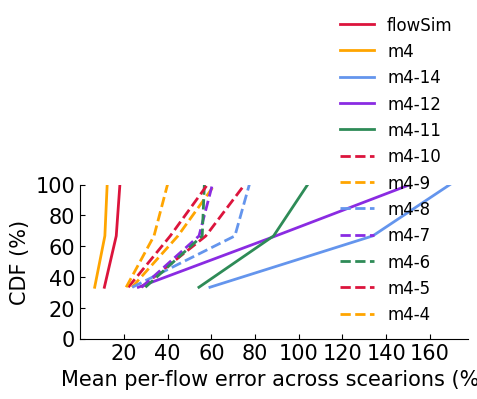

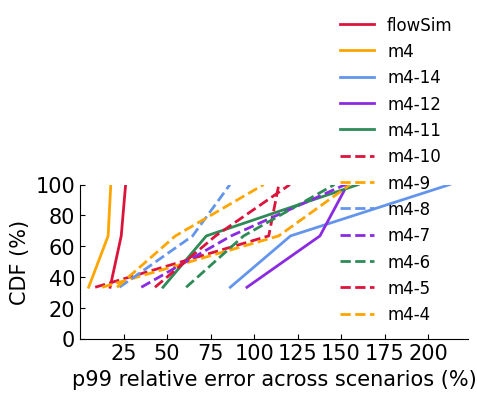

In [43]:
n_scenario=3
empirical_str = "eval_test"
# legend_list=['flowSim','m4','m4-12','m4-11']
# model_instance_list=['flowsim','final_10','final_noflowsim_12','final_noflowsim_11']
legend_list=['flowSim','m4','m4-14','m4-12','m4-11','m4-10','m4-9','m4-8','m4-7','m4-6','m4-5','m4-4','m4-3']
model_instance_list=['flowsim','final_10','final_loss07_12','final_loss07_10','final_loss07_11','final_loss07_9','final_loss07_8','final_loss07_7','final_loss07_6','final_loss07_5','final_loss07_4','final_loss07_3']
                     
n_methods = len(legend_list)
config_file=f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/spec/eval_test.mix.json'
configs=json.load(open(config_file))

index_list_ori=[]
for i in range(n_scenario):
    if os.path.exists(f'/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        index_list_ori.append(i)
index_list=[]
config_list=[]
for idx,i in enumerate(index_list_ori):
    config=configs[i]
    spatial=config['spatial'].split('/')[-1].split('.')[0]
    size_dist=config['size_dist'].split('/')[-1].split('.')[0]
    cluster=config['cluster'].split('/')[-1].split('.')[0]
    max_load=float(config['max_load'])
    lognorm_sigma=float(config['lognorm_sigma'])
    cc=config['cc']
    bfsz=float(config['bfsz'])
    fwin=float(config['window'])
    
    config_list.append([spatial, size_dist, cluster, max_load, lognorm_sigma,cc,bfsz,fwin])
    index_list.append(idx)
config_list=np.array(config_list)

error_list=[]
error_list_p99=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['fct']
    predicted_sldns = sldn[index_list, :, 0]
    actual_sldns = sldn[index_list,:, 1]
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.mean(np.abs(actual_sldns - predicted_sldns) / actual_sldns *100, axis=1)
    # relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_p99_est=np.percentile(predicted_sldns,99,axis=1)
    sldn_p99_act=np.percentile(actual_sldns,99,axis=1)
    
    error_list.append(relative_error_sldn)
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
config_list=config_list[index_list]
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)

# print(f"p99 error:{[np.percentile(x,99) for x in error_list]}")
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"median error:{[np.median(x) for x in error_list]}")
print(f"p99 error:{[np.mean(x) for x in error_list_p99]}")

plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Mean per-flow error across scearions (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=0,
)

plot_cdf(
    error_list_p99,
    None,
    legend_list,
    x_label="p99 relative error across scenarios (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
    fig_idx=1,
)

# Discretize the max_load values
max_load_values = np.array([config[3] for config in config_list], dtype=float)
bins = [0.3, 0.4,0.5, 0.6, 0.7, 0.8]
labels = ['0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8']
max_load_bins = np.digitize(max_load_values, bins, right=False) - 1
max_load_labels = [labels[i] for i in max_load_bins]
for idx, config in enumerate(config_list):
    config[3] = max_load_labels[idx]
    
bfsz_values = np.array([config[6] for config in config_list], dtype=float)
bins = [10,12,14,16,18,20]
labels = ['10-12', '12-14', '14-16', '16-18', '18-20']
bfsz_bins = np.digitize(bfsz_values, bins, right=False) - 1
bfz_labels = [labels[i] for i in bfsz_bins]
for idx, config in enumerate(config_list):
    config[6] = bfz_labels[idx]

fwin_values=np.array([config[7] for config in config_list], dtype=float)
bins = [10000,12000,14000,16000,18000,20000]
labels = ['10000-12000', '12000-14000', '14000-16000', '16000-18000', '18000-20000']
fwin_bins = np.digitize(fwin_values, bins, right=False) - 1
fwin_labels = [labels[i] for i in fwin_bins]
for idx, config in enumerate(config_list):
    config[7] = fwin_labels[idx]
# Convert config_list to a NumPy array for easier indexing
config_list = np.array(config_list)


# Function to plot box plots for each configuration type
# def plot_box_by_config(error_list, config_list, legend_list, config_index, config_name):
#     unique_configs = np.unique(config_list[:, config_index])
#     n_methods = len(legend_list)
    
#     # Prepare data for each unique configuration type
#     data_to_plot = {config_value: [[] for _ in range(n_methods)] for config_value in unique_configs}
#     for i, config_value in enumerate(config_list[:, config_index]):
#         for j in range(n_methods):
#             data_to_plot[config_value][j].append(error_list[i, j])
    
#     # Plot the data
#     plt.figure(figsize=(10, 6))
#     x_positions = np.arange(len(unique_configs))
#     box_width = 0.8 / n_methods  # Adjust width based on number of methods
#     colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
#     handles = []
    
#     for j, method_label in enumerate(legend_list):
#         method_data = [data_to_plot[config_value][j] for config_value in unique_configs]
#         positions = x_positions - 0.4 + (j + 0.5) * box_width  # Center the boxes
#         bp = plt.boxplot(method_data, positions=positions, widths=box_width,
#                          patch_artist=True, 
#                          boxprops=dict(facecolor=colors[j % len(colors)], color=colors[j % len(colors)]),
#                          medianprops=dict(color="black"))
#         handles.append(bp["boxes"][0])

#     plt.title(f"Relative Error by {config_name} Configuration")
#     plt.xlabel(config_name)
#     plt.ylabel("Relative Error (%)")
#     plt.xticks(x_positions, unique_configs, rotation=45)
#     plt.legend(handles, legend_list)
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# Generate plots for each configuration attribute
config_attributes = ["Spatial", "Size Distribution", "Cluster", "Max Load", "Lognorm Sigma", "CC", "BFSZ", "FWIN"]
for i, config_name in enumerate(config_attributes):
    plot_box_by_config(error_list.T, config_list, legend_list, config_index=i, config_name=config_name)

flowsim_large0-sldn: (85584,)
p99 slowdown: 2.70716249702616, 3.3371159918619004
m4_10_large0-sldn: (85584,)
p99 slowdown: 3.584040670394889, 3.3371159918619004
mean error:[19.796066156243874, 8.041182822247826]
p99 error: [18.87718306  7.3993436 ]


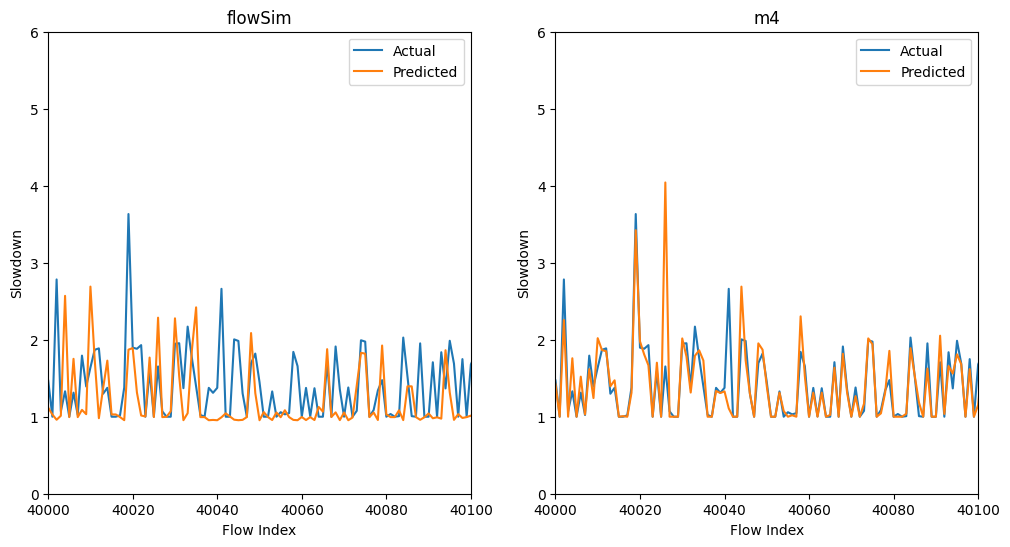

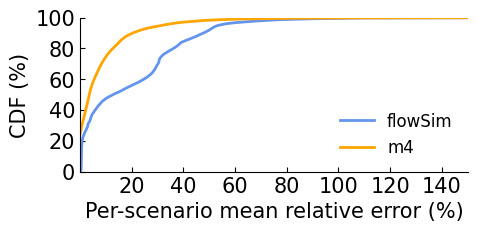

In [ ]:
empirical_str = ""
scenario_str="_large0"
# scenario_str=""
# legend_list=['flowSim','m4-flowsim-input','m4-final']
# model_instance_list=[f'flowsim{scenario_str}', f'topo_512_flowsim_input_dropout_19{scenario_str}',f'topo_reprod_19{scenario_str}']
# legend_list=['flowSim','m4','m4-data']
# model_instance_list=[f'flowsim{scenario_str}', f'topo_featrate_7{scenario_str}', f'topo_remainsize_large_data_7{scenario_str}']
# legend_list=['flowSim','m4-pre','m4']
# model_instance_list=[f'flowsim{scenario_str}', f'topo_featrate_7{scenario_str}',f'final_7{scenario_str}']
# legend_list=['flowSim','m4','m4-param']
# model_instance_list=[f'flowsim{scenario_str}',f'final_7{scenario_str}',f'final_param_6{scenario_str}']
# legend_list=['flowSim','m4','m4-GNN','m4-GNN-queue']
# model_instance_list=[f'flowsim{scenario_str}',f'final_param_6{scenario_str}',f"final_gnn_layer4_4{scenario_str}",f'm4_15{scenario_str}']
# legend_list=['flowSim','m4','m4-Queue','m4-noflowsim']
# model_instance_list=[f'flowsim{scenario_str}',f'final_param_6{scenario_str}',f'm4_15{scenario_str}',f"m4_noflowsim_9{scenario_str}"]
# legend_list=['flowSim','m4','m4-Queue','m4-16','m4-10']
# model_instance_list=[f'flowsim{scenario_str}',f'bm4_14{scenario_str}',f'bm4_15{scenario_str}',f"m4_16{scenario_str}",f"m4_10{scenario_str}"]
legend_list=['flowSim','m4']
model_instance_list=[f'flowsim{scenario_str}',f"m4_10{scenario_str}"]
                     
error_list=[]
error_list_p99=[]
sldn_list=[]
for model_instance in model_instance_list:
    data_m4 = np.load(f'./res/{model_instance}{empirical_str}.npz')
    sldn = data_m4['sldn']
    predicted_sldns = sldn[:, :, 0].squeeze()
    actual_sldns = sldn[:,:, 1].squeeze()
    print(f"{model_instance}-sldn: {predicted_sldns.shape}")
    
    predicted_sldns[predicted_sldns==0]=1
    actual_sldns[actual_sldns==0]=1
    # calculate the relative error
    relative_error_sldn = np.abs(actual_sldns - predicted_sldns) / actual_sldns *100
    sldn_list.append([actual_sldns,predicted_sldns])
    error_list.append(relative_error_sldn)
    
    sldn_p99_est=np.percentile(predicted_sldns,99)
    sldn_p99_act=np.percentile(actual_sldns,99)
    print(f"p99 slowdown: {sldn_p99_est}, {sldn_p99_act}")
    error_list_p99.append(np.abs(sldn_p99_est-sldn_p99_act)/sldn_p99_act*100)
error_list=np.array(error_list)
error_list_p99=np.array(error_list_p99)
sldn_list=np.array(sldn_list)
print(f"mean error:{[np.mean(x) for x in error_list]}")
print(f"p99 error: {error_list_p99}")
      
# Plotting
fig, axes = plt.subplots(1, len(model_instance_list), figsize=(12, 6))

# Plot each method in a subfigure
for i, (actual, predicted) in enumerate(sldn_list):
    axes[i].plot(actual, label="Actual")
    axes[i].plot(predicted, label="Predicted")
    axes[i].set_title(legend_list[i])
    axes[i].set_xlabel("Flow Index")
    axes[i].set_ylabel("Slowdown")
    axes[i].legend()
    axes[i].set_xlim(40000, 40100)
    axes[i].set_ylim(0, 6)
plot_cdf(
    error_list,
    None,
    legend_list,
    x_label="Per-scenario mean relative error (%)",
    log_switch=False,
    rotate_xaxis=False,
    # ylim_low=200,
    xlim=150,
    xlim_bottom=0.01,
    fontsize=15,
    legend_font=12,
    loc=4,
    enable_abs=True,
    group_size=5,
)

ns-3: 94
m4: 94
ns-3: 2907.9704255319148, m4: 241.19317416941865, flowsim: 56.40186381340027


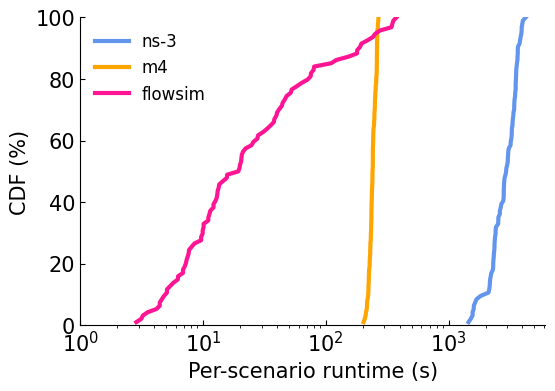

In [ ]:
import re
n_scenario=100
empirical_str='eval_test_8k'
data_root="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8"
legend_list=['ns-3', 'm4', 'flowsim']
res=[]

time_ns3=[]
'''
for i in range(n_scenario):
    if os.path.exists(f'{data_root}/{empirical_str}/{i}/ns3/flowsim_fct.npy'):
        time_file=f'{data_root}/{empirical_str}/{i}/ns3/elapsed.txt'
        with open(time_file, "r") as file:
            number = float(file.read().strip())
            time_ns3.append(number)
res.append(time_ns3)     
print(f"ns-3: {len(time_ns3)}")  
'''

with open(f'{data_root}/{empirical_str}/ns3_times.txt') as f:
    time_ns3 = [float(txt.replace("\n", "")) for txt in f.readlines()]

print(f"ns-3: {len(time_ns3)}")  
res.append(time_ns3)

def read_log_file(file_path):
    try:
        with open(file_path, 'r') as file:
            log_text = file.read()
        return log_text
    except FileNotFoundError:
        print(f"Error: The file {file_path} was not found.")
        return None

def extract_scenario_times(log_text):
    # Regex patterns for time elapsed and workload scenario
    time_pattern = r"Time elapsed:\s([\d.]+)"

    # Extract times and workload IDs
    elapsed_times = re.findall(time_pattern, log_text)

    # Create a dictionary mapping scenario ID to time elapsed
    scenario_times = []
    for workload_idx, time in enumerate(elapsed_times):
        time=float(time)
        scenario_times.append(float(time))
    
    return scenario_times

log_text = read_log_file(f'{empirical_str}.log')
time_m4 = extract_scenario_times(log_text)
res.append(time_m4)
print(f"m4: {len(time_m4)}")

with open(f'{data_root}/{empirical_str}/flowsim_times.txt') as f:
    flowsim_times = [float(txt.replace("\n", "")) for txt in f.readlines()]

res.append(flowsim_times)

res=np.array(res)
print(f"ns-3: {np.mean(res[0])}, m4: {np.mean(res[1])}, flowsim: {np.mean(res[2])}")

fig_index=0
plot_cdf(
    res,
    None,
    legend_list,
    x_label="Per-scenario runtime (s)",
    log_switch=True,
    rotate_xaxis=False,
    # ylim_low=90,
    # xlim=150,
    xlim_bottom=1,
    fontsize=15,
    legend_font=12,
    loc=2,
    enable_abs=True,
    group_size=5,
    fig_idx=fig_index
)
fig_index=1